In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the CSV file from Google Drive
data = pd.read_csv('/content/drive/MyDrive/Portfolio/Clustering/CCGENERAL.csv')

# Print the first rows
print(data.head())


In [ ]:
# Explore the data
print("Train shape:", data.shape)
print("Train info:")
print(data.info())
print("Train data summary statistics:")
print(data.describe())


Train shape: (8949, 16)
Train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8949 entries, 0 to 8949
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CUST_ID                     8949 non-null   object 
 1   BALANCE                     8949 non-null   float64
 2   BALANCE_FREQUENCY           8949 non-null   float64
 3   INSTALLMENTS_PURCHASES      8949 non-null   float64
 4   CASH_ADVANCE                8949 non-null   float64
 5   ONEOFF_PURCHASES_FREQUENCY  8949 non-null   float64
 6   CASH_ADVANCE_FREQUENCY      8949 non-null   float64
 7   CASH_ADVANCE_TRX            8949 non-null   int64  
 8   PURCHASES_TRX               8949 non-null   int64  
 9   CREDIT_LIMIT                8949 non-null   float64
 10  PAYMENTS                    8949 non-null   float64
 11  MINIMUM_PAYMENTS            8949 non-null   float64
 12  PRC_FULL_PAYMENT            8949 non-null   float64
 1

HANDLING MISSING VALUES

In [ ]:
# Drop row with missing 'CREDIT_LIMIT' value
data.dropna(subset=['CREDIT_LIMIT'], inplace=True)

# Impute missing values in 'MINIMUM_PAYMENTS' with mean
data['MINIMUM_PAYMENTS'].fillna(data['MINIMUM_PAYMENTS'].mean(), inplace=True)


In [ ]:
# Feature scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop('CUST_ID', axis=1))  # Scaling the numerical features, excluding the customer ID column
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])   # Create a new DataFrame with scaled features


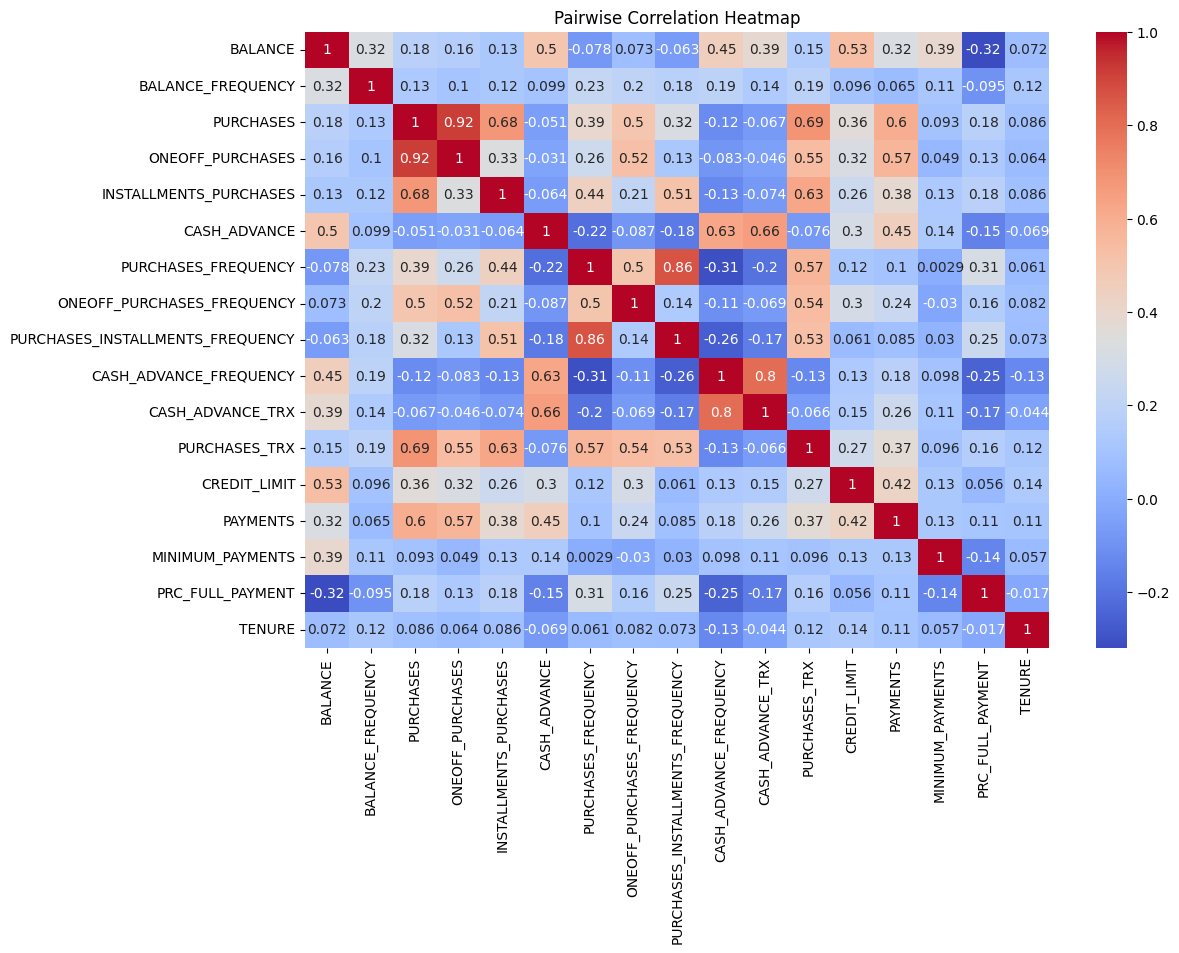

In [ ]:
# Pairwise correlation heatmap
correlation = data.drop('CUST_ID', axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Pairwise Correlation Heatmap')
plt.show()


CREATING TWO NEW FEATUREs BY PCA

A high correlation of 0.92 between 'ONEOFF_PURCHASES' and 'PURCHASES' and
0.86 between 'PURCHASES_INSTALLMENTS_FREQUENCY' and 'PURCHASES_FREQUENCY' suggests a strong linear relationship between these variable pairs. This high correlation indicates that these feature pairs capture similar information about the data. I will apply PCA to these  feature pairs, and create new features called 'PCA_PURCHASES' and 'PCA_FREQUENCY' to capture the principal component representing the most important information from these correlated features. The original highly correlated features will then dropped from the dataset.

In [ ]:
# Create a new DataFrame with the features of interest
features1 = ['ONEOFF_PURCHASES', 'PURCHASES']
selected_features1 = data[features1]

# Apply PCA to reduce dimensionality
pca1 = PCA(n_components=1)
pca1_data = pca1.fit_transform(selected_features1)

# Replace the original features with the PCA-transformed feature
data['PCA_PURCHASES'] = pca1_data

# Create a new DataFrame with the features of interest
features2 = ['PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_FREQUENCY']
selected_features2 = data[features2]

# Apply PCA to reduce dimensionality
pca2 = PCA(n_components=1)
pca2_data = pca2.fit_transform(selected_features2)

# Replace the original features with the PCA-transformed feature
data['PCA_FREQUENCY'] = pca2_data

# Drop the original highly correlated features
data.drop(['ONEOFF_PURCHASES', 'PURCHASES','PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_FREQUENCY'], axis=1, inplace=True)


STANDARDIZING DATA
the range of values differs considerably across different features. Standardization will help address the issue of variables with significantly different ranges and ensure that each feature contributes equally to the clustering process.

In [ ]:
# Feature scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop('CUST_ID', axis=1))  # Scaling the numerical features, excluding the customer ID column
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])   # Create a new DataFrame with scaled features
print(scaled_df.head())

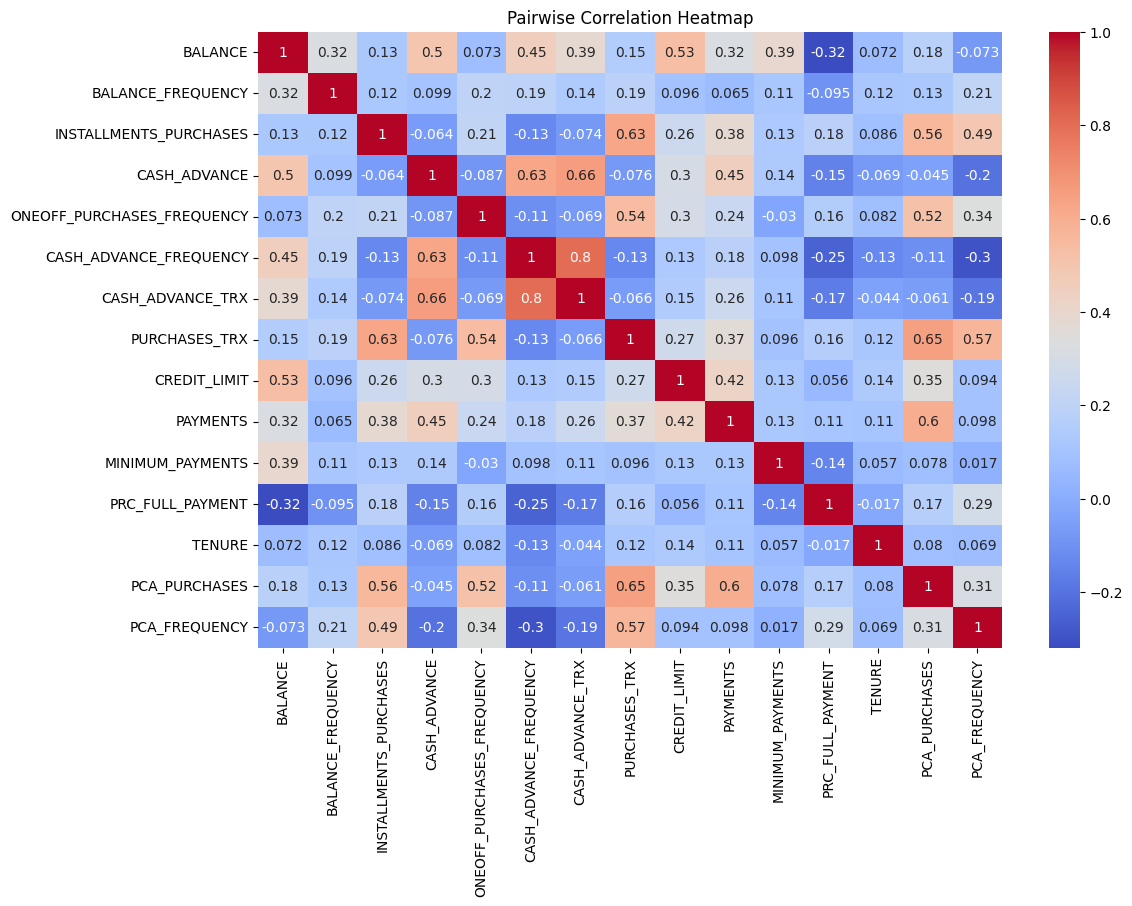

In [ ]:
# Pairwise correlation heatmap
correlation = scaled_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Pairwise Correlation Heatmap')
plt.show()


KMEANS CLUSTERING

In [ ]:
# Select the features for clustering
features = ['BALANCE', 'BALANCE_FREQUENCY','INSTALLMENTS_PURCHASES',
            'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY',
            'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX',
            'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'PCA_PURCHASES', 'PCA_FREQUENCY']

# Create a list to store the inertia (within-cluster sum of squares) values
inertia = []

# Perform K-means clustering for a range of K values
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df[features])
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.show()


# 3 is the optimal value for n_clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


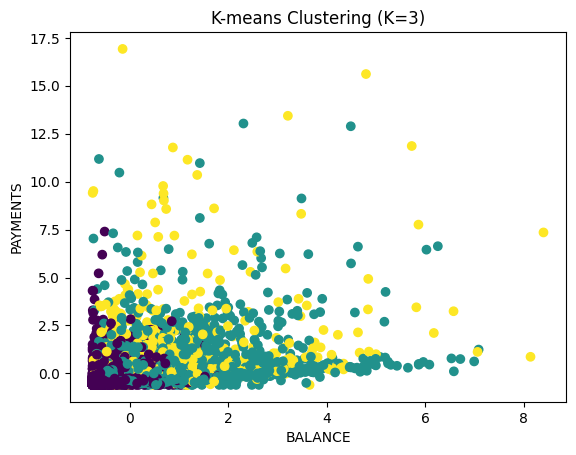

In [ ]:
# Perform K-means clustering with K=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_df[features])

# Visualize the clusters
plt.scatter(scaled_df['BALANCE'], scaled_df['PAYMENTS'], c=kmeans_labels, cmap='viridis')
plt.xlabel('BALANCE')
plt.ylabel('PAYMENTS')
plt.title('K-means Clustering (K=3)')
plt.show()


HIERARCHICAL CLUSTERING

In [ ]:
# Perform hierarchical clustering (Agglomerative)
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(scaled_df[features])

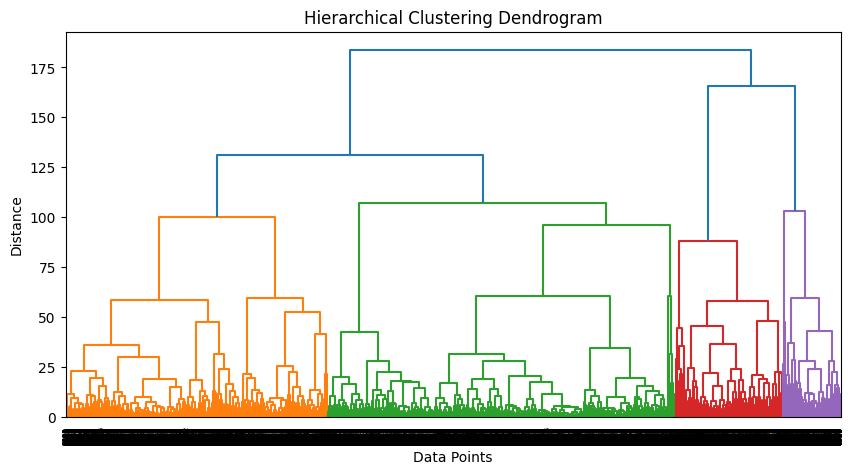

In [ ]:
from scipy.cluster import hierarchy

# Perform hierarchical clustering
hierarchical = hierarchy.linkage(scaled_df[features], method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(hierarchical)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


DBSCAN

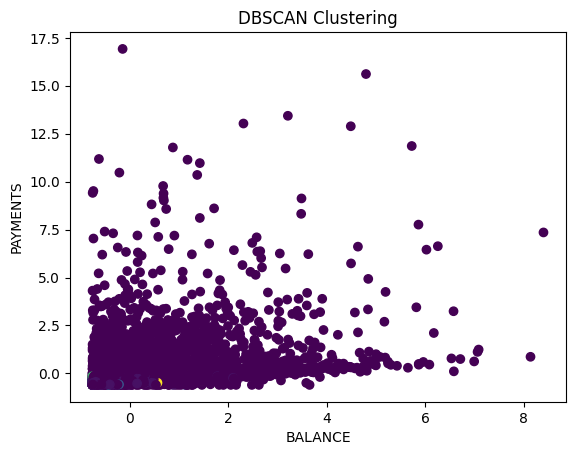

In [ ]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_df[features])

# Visualize the clusters
plt.scatter(scaled_df['BALANCE'], scaled_df['PAYMENTS'], c=dbscan_labels, cmap='viridis')
plt.xlabel('BALANCE')
plt.ylabel('PAYMENTS')
plt.title('DBSCAN Clustering')
plt.show()